In [1]:
import torch
from torchvision import transforms

import torchvision.datasets as datasets
# Using CIFAR-10 dataset
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

from torchvision import models

import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange

from tqdm.notebook import tqdm, trange
import os
from torchvision.datasets import ImageFolder
import tarfile

# Define the transformations
transform = transforms.Compose([
    transforms.Resize(160),               # resize to 160×160 for imagenette2-160
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5)),
])
# Paths for the Imagenette dataset (assumes you want it under ./data/imagenette2-160/)
imagenette_root = "./data/imagenette2-160"
train_dir = os.path.join(imagenette_root, "train")
val_dir   = os.path.join(imagenette_root, "val")

# download & extract if not already present
if not os.path.isdir(imagenette_root):
    os.makedirs(os.path.dirname(imagenette_root), exist_ok=True)
    url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
    archive_path = os.path.join(os.path.dirname(imagenette_root), "imagenette2-160.tgz")
    if not os.path.exists(archive_path):
        print("Downloading Imagenette dataset...")
        import urllib.request
        urllib.request.urlretrieve(url, archive_path)
    print("Extracting Imagenette dataset...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=os.path.dirname(imagenette_root))
    print("Done.")

# Load the Imagenette dataset
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset  = ImageFolder(val_dir,   transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=512, shuffle=False)

In [2]:
resnet_pretrained_18 = models.resnet18(pretrained=True)
resnet_pretrained_18.fc = torch.nn.Identity()

resnet_pretrained_50 = models.resnet50(pretrained=True)
resnet_pretrained_50.fc = torch.nn.Identity()

resnet_pretrained_152 = models.resnet152(pretrained=True)
resnet_pretrained_152.fc = torch.nn.Identity()

labels_list = np.load('labels_list_imagenette_1.npy')

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-

In [3]:
# ── 1. Build a “multi-label” view of the data ──────────────────────────────────
labels_matrix = np.stack(labels_list)          # (100, N)
labels_matrix = torch.from_numpy(labels_matrix).float()  # to tensor

class MultiTaskWrapper(torch.utils.data.Dataset):
    def __init__(self, base_ds, all_labels):
        self.base_ds   = base_ds               # the dataset behind your test_loader
        self.all_lbls  = all_labels            # (100, N)
    def __len__(self): return len(self.base_ds)
    def __getitem__(self, idx):
        img, _    = self.base_ds[idx]
        lbl_vec   = self.all_lbls[:, idx]      # (100,)
        return img, lbl_vec

multi_ds     = MultiTaskWrapper(test_loader.dataset, labels_matrix)
multi_loader = torch.utils.data.DataLoader(multi_ds,
                                           batch_size=test_loader.batch_size,
                                           shuffle=False,
                                           num_workers=test_loader.num_workers,
                                           pin_memory=True)

# ── 2. Multi-task linear probe ─────────────────────────────────────────────────
def linear_probe_multi(model, loader, feat_dim = 2048, n_epoch=1):
    n_tasks = 256
    model.eval().cuda()

    head = torch.nn.Linear(feat_dim, n_tasks).cuda()
    crit = torch.nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(head.parameters(), lr=1e-2)
    
    # Add cosine annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt,
        T_max=n_epoch,  # Total number of epochs
        eta_min=1e-6    # Minimum learning rate
    )

    for epoch in trange(n_epoch):
        runloss = 0.
        for imgs, lbls in loader:                  # lbls → (B, 100)
            imgs = torch.nn.functional.interpolate(
                imgs, size=(224,224), mode='bilinear', align_corners=False
            ).cuda(non_blocking=True)
            lbls = lbls.cuda(non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():        # mixed precision, optional
                feats = model(imgs)                # (B, 1000)
                logits = head(feats)               # (B, n_tasks)
                loss = crit(logits, lbls)
            loss.backward()
            opt.step()
            runloss += loss.item()

        # Step the scheduler after each epoch
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

    # ─ Evaluation per task ─
    correct = torch.zeros(n_tasks, device='cuda')
    total   = torch.zeros(n_tasks, device='cuda')

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs  = torch.nn.functional.interpolate(
                        imgs, size=(224,224), mode='bilinear', align_corners=False
                    ).cuda(non_blocking=True)
            lbls  = lbls.cuda(non_blocking=True)

            preds   = (head(model(imgs)) > 0).float()
            correct += (preds == lbls).sum(dim=0)
            total   += lbls.size(0)

    acc = (100*correct/total).cpu().numpy()        # shape (100,)
    return acc

In [4]:
# ── 3. Run it ──────────────────────────────────────────────────────────────────
pre_task_accuracies_18 = linear_probe_multi(resnet_pretrained_18, feat_dim=512, loader = multi_loader, n_epoch=30)
pre_task_accuracies_50 = linear_probe_multi(resnet_pretrained_50, feat_dim=2048, loader = multi_loader, n_epoch=30)

# Clear VRAM
torch.cuda.empty_cache()

pre_task_accuracies_152 = linear_probe_multi(resnet_pretrained_152, feat_dim=2048, loader = multi_loader, n_epoch=30)

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_38788/1351666166.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():        # mixed precision, optional


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

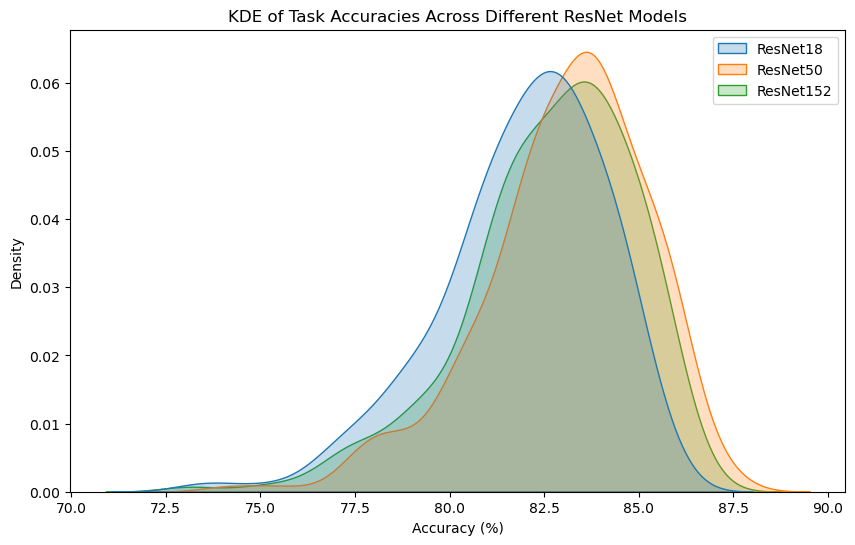

: 

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists to pandas Series
s18 = pd.Series(pre_task_accuracies_18, name='ResNet18')
s50 = pd.Series(pre_task_accuracies_50, name='ResNet50')
s152 = pd.Series(pre_task_accuracies_152, name='ResNet152')

# Combine into a DataFrame for easier plotting
df = pd.concat([s18, s50, s152], axis=1)

# Create KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, fill=True)
plt.title('KDE of Task Accuracies Across Different ResNet Models')
plt.xlabel('Accuracy (%)')
plt.ylabel('Density')
plt.show()